Reference for where this was taken from: * https://github.com/llSourcell/seq2seq_model_live/blob/master/2-seq2seq-advanced.ipynb
* Also for reference: http://suriyadeepan.github.io/2016-06-28-easy-seq2seq/

In [1]:
import numpy as np # matrix math
import tensorflow as tf 
import helpers # don't have from video


print('tf.__version__:',tf.__version__)
tf.reset_default_graph()
sess = tf.InteractiveSession()

tf.__version__: 1.8.0


In [2]:
## Defining vocabulary size

# What to padd the sequence when sequences are not the same length
PAD = 0
# WHen our sentences 
EOS = 1
# Definining max length for input sequence
vocab_size = 10
#
input_embedding_size = 20 # character length

## Defining hidden units
encoder_hidden_units = 20
# Define the decoder to be a little different than the input...so multiply by 2
decoder_hidden_units = encoder_hidden_units * 2

In [3]:
#input placehodlers
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
#contains the lengths for each of the sequence in the batch, we will pad so all the same
#if you don't want to pad, check out dynamic memory networks to input variable length sequences
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')



In [4]:
#randomly initialized embedding matrrix that can fit input sequence
#used to convert sequences to vectors (embeddings) for both encoder and decoder of the right size
#reshaping is a thing, in TF you gotta make sure you tensors are the right shape (num dimensions)
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

#this thing could get huge in a real world application
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

We use tf.nn.embedding_lookup to index embedding matrix: given word 4, we represent it as 4th column of embedding matrix. This operation is lightweight, compared with alternative approach of one-hot encoding word 4 as [0,0,0,1,0,0,0,0,0,0] (vocab size 10) and then multiplying it by embedding matrix.

Additionally, we don't need to compute gradients for any columns except 4th.

**In real NLP application embedding matrix can get very large, with 100k or even 1m columns.**


In [5]:
## Define encoder
from tensorflow.python.ops.rnn_cell import LSTMStateTuple, LSTMCell

In [6]:
encoder_cell = LSTMCell(encoder_hidden_units)

In [7]:
#get outputs and states
#bidirectional RNN function takes a separate cell argument for 
#both the forward and backward RNN, and returns separate 
#outputs and states for both the forward and backward RNN

#When using a standard RNN to make predictions we are only taking the “past” into account. 
#For certain tasks this makes sense (e.g. predicting the next word), but for some tasks 
#it would be useful to take both the past and the future into account. Think of a tagging task, 
#like part-of-speech tagging, where we want to assign a tag to each word in a sentence. 
#Here we already know the full sequence of words, and for each word we want to take not only the 
#words to the left (past) but also the words to the right (future) into account when making a prediction. 
#Bidirectional RNNs do exactly that. A bidirectional RNN is a combination of two RNNs – one runs forward from 
#“left to right” and one runs backward from “right to left”. These are commonly used for tagging tasks, or 
#when we want to embed a sequence into a fixed-length vector (beyond the scope of this post).


((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, time_major=True)
    )

Example sentence:
"How are you?"
* Vectorize the sentence
* Feed the vector to the encoder
* **1 full time step, t:** encoder to hidden state
    * Hidden state and previous are fed in to back propogation, so we are backpropogating through time
* Feed that vector to decoder


**It is better in every circumstance to have a bi-directional layer, but of course it is always going to be more computationally expensive**

In [8]:
#Concatenates tensors along one dimension.
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

#letters h and c are commonly used to denote "output value" and "cell state". 
#http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
#Those tensors represent combined internal state of the cell, and should be passed together. 

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

#TF Tuple used by LSTM Cells for state_size, zero_state, and output state.
encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

In [9]:
## Defining decoder: 
## Batches are subsets of the data.

decoder_cell = LSTMCell(decoder_hidden_units)
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))
# We want the decoder to be a little bigger than the input sequence. We don't yet know if the
# sentence has ended yet.
decoder_lengths = encoder_inputs_length + 3

In [10]:
# Output projection: Weights and biases
## Going into more detail with the decoder as far as defining the decoder because we want to define
## the weights manually.

#manually specifying since we are going to implement attention details for the decoder in a sec
#weights
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
#bias
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

In [11]:
#create padded inputs for the decoder from the word embeddings

#were telling the program to test a condition, and trigger an error if the condition is false.
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

#retrieves rows of the params tensor. The behavior is similar to using indexing with arrays in numpy
eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

In [12]:
#manually specifying loop function through time - to get initial cell state and input to RNN
#normally we'd just use dynamic_rnn, but lets get detailed here with raw_rnn

#we define and return these values, no operations occur here
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    #end of sentence
    initial_input = eos_step_embedded
    #last time steps cell state
    initial_cell_state = encoder_final_state
    #none
    initial_cell_output = None
    #none
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)



In [13]:
#attention mechanism --choose which previously generated token to pass as input in the next timestep
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    
    def get_next_input():
        #dot product between previous ouput and weights, then + biases
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        #Logits simply means that the function operates on the unscaled output of 
        #earlier layers and that the relative scale to understand the units is linear. 
        #It means, in particular, the sum of the inputs may not equal 1, that the values are not probabilities 
        #(you might have an input of 5).
        #prediction value at current time step
        
        #Returns the index with the largest value across axes of a tensor.
        prediction = tf.argmax(output_logits, axis=1)
        #embed prediction for the next input
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    
    
    #Computes the "logical and" of elements across dimensions of a tensor.
    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    #Return either fn1() or fn2() based on the boolean predicate pred.
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    
    #set previous to current
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

Combine initializer and transition functions and create raw_rnn.

Note that while all operations above are defined with TF's control flow and reduction ops, here we rely on checking if state is None to determine if it is an initializer call or transition call. This is not very clean API and might be changed in the future (indeed, tf.nn.raw_rnn's doc contains warning that API is experimental).


In [14]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

#Creates an RNN specified by RNNCell cell and loop function loop_fn.
#This function is a more primitive version of dynamic_rnn that provides more direct access to the 
#inputs each iteration. It also provides more control over when to start and finish reading the sequence, 
#and what to emit for the output.
#ta = tensor array
decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

To do output projection, we have to temporarilly flatten decoder_outputs from [max_steps, batch_size, hidden_dim] to [max_steps*batch_size, hidden_dim], as tf.matmul needs rank-2 tensors at most.

In [15]:
#to convert output to human readable prediction
#we will reshape output tensor

#Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#reduces dimensionality
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
#flettened output tensor
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
#pass flattened tensor through decoder
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
#prediction vals
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [16]:
#final prediction
decoder_prediction = tf.argmax(decoder_logits, 2)



## Optimizer



RNN outputs tensor of shape [max_time, batch_size, hidden_units] which projection layer maps onto [max_time, batch_size, vocab_size]. vocab_size part of the shape is static, while max_time and batch_size is dynamic.


In [17]:
#cross entropy loss
#one hot encode the target values so we don't rank just differentiate
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

#loss function
loss = tf.reduce_mean(stepwise_cross_entropy)
#train it 
train_op = tf.train.AdamOptimizer().minimize(loss)



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [18]:
sess.run(tf.global_variables_initializer())

## Training on the toy task

Consider the copy task — given a random sequence of integers from a vocabulary, learn to memorize and reproduce input sequence. Because sequences are random, they do not contain any structure, unlike natural language.


In [19]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[7, 5, 8, 5, 6, 5, 9]
[7, 4, 6, 4, 3, 6, 3, 8]
[2, 9, 4]
[9, 2, 2, 8, 5]
[7, 3, 5]
[2, 9, 3, 3, 3, 9, 5]
[4, 3, 3, 7, 2, 8, 8, 3]
[5, 2, 3, 3]
[5, 6, 3, 7, 2, 7, 3, 5]
[3, 7, 7, 6]


In [20]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [21]:
loss_track = []

In [22]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.372451066970825
  sample 1:
    input     > [7 6 9 0 0 0 0 0]
    predicted > [5 5 5 5 6 8 0 0 0 0 0]
  sample 2:
    input     > [9 7 6 4 9 3 5 5]
    predicted > [5 5 5 5 5 5 6 8 6 8 2]
  sample 3:
    input     > [9 4 9 5 6 0 0 0]
    predicted > [5 5 5 5 5 6 8 6 0 0 0]

batch 1000
  minibatch loss: 0.5512381792068481
  sample 1:
    input     > [7 7 3 5 9 5 6 0]
    predicted > [7 7 3 5 5 5 6 1 0 0 0]
  sample 2:
    input     > [3 3 8 3 5 6 0 0]
    predicted > [3 3 3 8 5 6 1 0 0 0 0]
  sample 3:
    input     > [5 8 6 0 0 0 0 0]
    predicted > [5 8 6 1 0 0 0 0 0 0 0]

batch 2000
  minibatch loss: 0.27681127190589905
  sample 1:
    input     > [2 2 7 2 0 0 0 0]
    predicted > [2 2 7 2 1 0 0 0 0 0 0]
  sample 2:
    input     > [2 2 3 3 7 6 7 0]
    predicted > [2 2 3 3 3 6 7 1 0 0 0]
  sample 3:
    input     > [7 7 2 2 0 0 0 0]
    predicted > [7 7 2 2 1 0 0 0 0 0 0]

batch 3000
  minibatch loss: 0.18458035588264465
  sample 1:
    input     > [2 8 

loss 0.1853 after 300100 examples (batch_size=100)


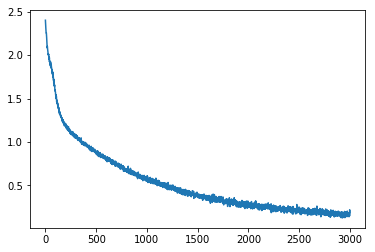

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))